In [114]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

https://medium.com/@datadote/pytorch-matrix-factorization-pictures-code-part-1-abe331317ffb

https://github.com/Datadote/matrix-factorization-pytorch/blob/master/01_matrix_fact_simple.ipynb

In [115]:
user_item_interactions_df = pd.read_csv('../tests/test_data/user_item_interactions.csv', parse_dates=['date'])

user_item_interactions_df.head()

,user_id,item_id,date,count
0,U002120,I00006767,2024-07-02,1.0
1,U000748,I00001418,2024-07-02,1.0
2,U004334,I00002579,2024-07-02,1.0
3,U002062,I00000098,2024-07-02,1.0
4,U001214,I00009416,2024-07-02,1.0


In [116]:
from sklearn.preprocessing import LabelEncoder

# filter interactions to include only users with >= 15 interactions

interactions = user_item_interactions_df.groupby('user_id').filter(lambda x: len(x) >= 15)

# sort for train test split
interactions = interactions.sort_values(['user_id', 'date'], ascending=[True, True]).reset_index(drop=True)

# create ratings column
interactions['rating'] = np.clip(interactions['count'], a_max=5, a_min=1) / 5
interactions.drop(['count', 'date'], axis=1, inplace=True)

unique_users = interactions.user_id.drop_duplicates()
unique_items = interactions.item_id.drop_duplicates()

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

interactions['user_id'] = user_encoder.fit_transform(interactions['user_id'])
interactions['item_id'] = item_encoder.fit_transform(interactions['item_id'])

print(unique_users.shape, unique_items.shape, interactions.shape)

interactions.head()

(58,) (1711,) (1714, 3)


,user_id,item_id,rating
0,0,637,0.2
1,0,185,0.2
2,0,76,0.2
3,0,1362,0.2
4,0,202,0.2


In [117]:
df_train = interactions.groupby('user_id').head(-5).reset_index(drop=True)
df_val = interactions.groupby('user_id').tail(5).reset_index(drop=True)
df_train.shape, df_val.shape

((1424, 3), (290, 3))

In [118]:
class UserItemDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df[['user_id', 'item_id', 'rating']]
        self.X = list(zip(df.user_id.values, df.item_id.values))
        self.y = self.df.rating.values
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [119]:
batch_size = 128
ds_train = UserItemDataset(df_train)
ds_val = UserItemDataset(df_val)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)

xb, yb = next(iter(dl_train))
xb, yb

([tensor([53, 44, 50, 13, 46, 26,  3, 45, 48, 54, 46,  8,  3, 35, 50, 47,  6, 26,
          44, 13, 21, 24, 46, 57,  0,  5, 43, 44, 13,  7, 12, 24, 23, 13, 56,  6,
          44,  0, 44,  2, 36, 49, 45, 22, 19, 45, 15, 50, 23,  6, 13, 15, 56, 16,
          21, 11, 33, 49, 18, 13,  1, 56, 44, 11, 57,  9,  2, 56, 44, 37, 23, 40,
          34, 16, 56, 38, 44, 13, 34, 51, 41, 33,  4, 24,  6, 33, 44, 16, 48, 50,
          36, 13, 30,  9,  3, 44, 16, 13, 57, 19, 42, 20,  0, 46, 44, 55, 46,  9,
          44, 52, 46, 23, 20, 57,  5, 48, 24,  9, 24, 55, 44,  0, 56, 37, 52, 15,
          45, 24]),
  tensor([ 638, 1408,  132,  413, 1092,  392,  183,  138, 1607,  147, 1176, 1629,
          1364, 1026, 1635,  867,  899, 1339,  140,   74,  308, 1055,   20,  996,
           322,  108,  292,   79,  769, 1512,   37,  765,  295,  730, 1606,  336,
           607,  464,  411,    4, 1454, 1511, 1489, 1036, 1623,  904,  837, 1182,
           141,  317, 1662,  490,  528, 1482,  966, 1206, 1013,  934,  614,   

In [120]:
class MF(nn.Module):
    """ Matrix factorization model """
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.item_embedding = nn.Embedding(num_embeddings=n_items, embedding_dim=embedding_dim)
    def forward(self, user, item):
        user_embedding = self.user_embedding(user)
        item_embedding = self.item_embedding(item)
        return (user_embedding*item_embedding).sum(1)

In [121]:
n_users = len(unique_users)
n_items = len(unique_items)

model = MF(n_users, n_items, embedding_dim=32)
model.to(device)
model

MF(
  (user_embedding): Embedding(58, 32)
  (item_embedding): Embedding(1711, 32)
)

In [122]:
LEARNING_RATE = 0.2
NUM_EPOCHS = 20

opt = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
epoch_train_losses, epoch_val_losses = [], []

for i in range(NUM_EPOCHS):
    train_losses, val_losses = [], []
    model.train()
    for xb,yb in dl_train:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = model(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    model.eval()
    for xb,yb in dl_val:
        xUser = xb[0].to(device, dtype=torch.long)
        xItem = xb[1].to(device, dtype=torch.long)
        yRatings = yb.to(device, dtype=torch.float)
        preds = model(xUser, xItem)
        loss = loss_fn(preds, yRatings)
        val_losses.append(loss.item())
    # Start logging
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)
    print(f'Epoch: {i}, Train Loss: {epoch_train_loss:0.1f}, Val Loss:{epoch_val_loss:0.1f}')

Epoch: 0, Train Loss: 23.9, Val Loss:18.6
Epoch: 1, Train Loss: 56.0, Val Loss:12.0
Epoch: 2, Train Loss: 45.3, Val Loss:5.0
Epoch: 3, Train Loss: 17.7, Val Loss:3.9
Epoch: 4, Train Loss: 9.0, Val Loss:3.1
Epoch: 5, Train Loss: 3.9, Val Loss:2.3
Epoch: 6, Train Loss: 2.9, Val Loss:1.4
Epoch: 7, Train Loss: 1.4, Val Loss:1.0
Epoch: 8, Train Loss: 0.8, Val Loss:0.8
Epoch: 9, Train Loss: 0.9, Val Loss:1.0
Epoch: 10, Train Loss: 0.5, Val Loss:0.6
Epoch: 11, Train Loss: 0.4, Val Loss:0.6
Epoch: 12, Train Loss: 0.1, Val Loss:0.5
Epoch: 13, Train Loss: 0.1, Val Loss:0.4
Epoch: 14, Train Loss: 0.0, Val Loss:0.3
Epoch: 15, Train Loss: 0.0, Val Loss:0.3
Epoch: 16, Train Loss: 0.0, Val Loss:0.3
Epoch: 17, Train Loss: 0.0, Val Loss:0.3
Epoch: 18, Train Loss: 0.0, Val Loss:0.3
Epoch: 19, Train Loss: 0.0, Val Loss:0.2


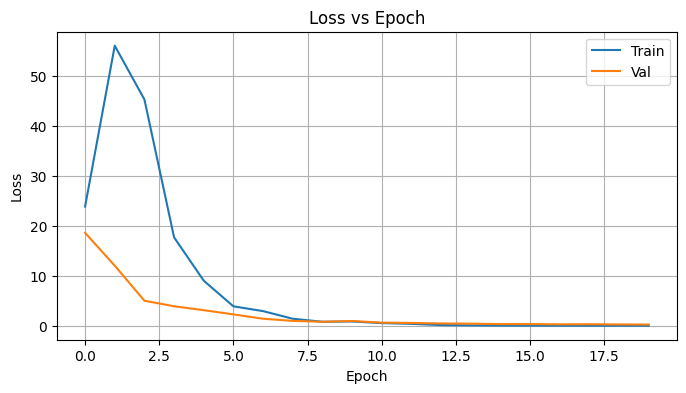

In [123]:
plt.figure(figsize=(8, 4))
plt.plot(epoch_train_losses, label='Train')
plt.plot(epoch_val_losses, label='Val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()